# SpQR application on a Higgs dataset


In this notebook we train the SpQR model on the dataset HIGGS.csv from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS).

This notebook is divided essentially in five parts:

    1. Downloading and preparing (slicing) the dataset
    2. Plotting features (to get an initial idea)
    3. Initializing the model
    4. Fitting and evaluating performances
    5. Plotting results


## Package needed

In [ ]:
! git clone https://github.com/MarcoRiggirello/SpQR-Flow.git
! cd SpQR-Flow

fatal: destination path 'SpQR-Flow' already exists and is not an empty directory.


In [ ]:
import sys
import os

py_file_location = "/content/SpQR-Flow/SpQR-Flow"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import imageio
from PIL import Image

from download import download_file

## Downloading data

To download the dataset we use the function download_file in the \texttt{download.py} module: it will check if the dataset already exists in the current directory or download it from the internet.

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
file_path = os.path.join('../model_test/download/HIGGS.csv.gz')
download_file(url, file_path)

## Plotting features of the dataset

We use seaborn to display scatterplot matrices of the correlation between features in the dataset.

In [ ]:
t0 = time.time()

column_labels = ['label','lepton pT', 'lepton eta', 'lepton phi',
                 'missing energy magnitude', 'missing energy phi',
                 'jet 1 pt', 'jet 1 eta', 'jet 1 phi',
                 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta',
                 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt',
                 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag',
                 'jet 4 pt', 'jet 4 eta', 'jet 4 phi',
                 'jet 4 b-tag', 'm_jj', 'm_jjj','m_lv',
                 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
data = pd.read_csv(file_path,
                   header=0,
                   names=column_labels,
                   nrows=8192*16)
t1 = time.time()
print(f'Time for reading all the data ~{(t1-t0):.0f} s')
"""
# Creating a gif of  correlation scatter plots                                                                        
tuple_var = [(1, 7), (8, 14), (15, 21), (22, 28)]
grid_list = [sns.PairGrid(data,
                          hue='label',
                          vars=column_labels[init:end],
                          corner=True)
             for init, end in tuple_var]

fig_list = []
for i, grid in enumerate(grid_list):
    grid.map_diag(sns.kdeplot)
    grid.map_offdiag(sns.kdeplot)
    grid.add_legend()
    fig_name = f'sns_plot{i}.png'
    grid.savefig(fig_name)
    fig_list.append(imageio.imread(fig_name))

imageio.mimsave('sns.gif',
                fig_list,
                duration = 5)
im = Image.open('sns.gif')
im.show()
"""

Time for reading all the data ~2 s


"\n# Creating a gif of  correlation scatter plots                                                                        \ntuple_var = [(1, 7), (8, 14), (15, 21), (22, 28)]\ngrid_list = [sns.PairGrid(data,\n                          hue='label',\n                          vars=column_labels[init:end],\n                          corner=True)\n             for init, end in tuple_var]\n\nfig_list = []\nfor i, grid in enumerate(grid_list):\n    grid.map_diag(sns.kdeplot)\n    grid.map_offdiag(sns.kdeplot)\n    grid.add_legend()\n    fig_name = f'sns_plot{i}.png'\n    grid.savefig(fig_name)\n    fig_list.append(imageio.imread(fig_name))\n\nimageio.mimsave('sns.gif',\n                fig_list,\n                duration = 5)\nim = Image.open('sns.gif')\nim.show()\n"

## Slicing data: train, validation, test

We slice the dataframe to obtain train and test samples.
Data appear to have mixed labels already, so that a simple slicing is sufficient to obtain good sampling.

There are 11 milions entries: the last 500k are used as tests, as in the [original paper](https://www.nature.com/articles/ncomms5308.pdf).

In [ ]:
BATCH_SIZE = 1024
DATASET_SIZE = BATCH_SIZE * 16
TEST_SIZE = BATCH_SIZE * 16

data_train = data[column_labels[1:22]].head(DATASET_SIZE).astype('float32')
data_test = data[column_labels[1:22]].tail(TEST_SIZE).astype('float32')

y_data = data[column_labels[0]].head(DATASET_SIZE).astype('int32')
y_test = data[column_labels[0]].tail(TEST_SIZE).astype('int32')


In [ ]:
print(data_train.head(2))
print(f'Train shape: {data_train.shape}; Test shape: {data_test.shape}')

print(y_data.head(2))
print(f'out data shape: {y_data.shape}; out test shape: {y_test.shape}')

   lepton pT  lepton eta  lepton phi  missing energy magnitude  \
0   0.907542    0.329147    0.359412                  1.497970   
1   0.798835    1.470639   -1.635975                  0.453773   

   missing energy phi  jet 1 pt  jet 1 eta  jet 1 phi  jet 1 b-tag  jet 2 pt  \
0           -0.313010  1.095531  -0.557525  -1.588230     2.173076  0.812581   
1            0.425629  1.104875   1.282322   1.381664     0.000000  0.851737   

   ...  jet 2 phi  jet 2 b-tag  jet 3 pt  jet 3 eta  jet 3 phi  jet 3 b-tag  \
0  ...   1.271015     2.214872  0.499994  -1.261432   0.732156     0.000000   
1  ...  -0.819690     2.214872  0.993490   0.356080  -0.208778     2.548224   

   jet 4 pt  jet 4 eta  jet 4 phi  jet 4 b-tag  
0  0.398701  -1.138930  -0.000819          0.0  
1  1.256955   1.128848   0.900461          0.0  

[2 rows x 21 columns]
Train shape: (16384, 21); Test shape: (16384, 21)
0    1
1    1
Name: label, dtype: int32
out data shape: (16384,); out test shape: (16384,)


## Building the DIGLM model

In the following block, we build our Deeply Invertible Generalized Linear Model (DIGLM) algorithm.
We will then be able to train the model on labelled data.

The steps to create and train the model are:

1. Create the desired transformed outputs from a simple distribution with the same dimensionality as the input data;
2. Initialize the NeuralSplineFlow bijector;
3. Initialize the DIGLM model;
4. Create the training step functions.


In [ ]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from tensorflow_probability import glm as tfglm
from tensorflow_probability import bijectors as tfb

from spqr import NeuralSplineFlow as NSF
from diglm import DIGLM


neural_spline_flow = NSF(splits=4)
glm = tfglm.Bernoulli()
NUM_FEATURES = 21

diglm = DIGLM(neural_spline_flow, glm, NUM_FEATURES)

In [ ]:
# testing DIGLM properties

print(diglm.num_features == NUM_FEATURES)
print('bijector ', diglm.bijector)
print('glm ', diglm.glm)


True
bijector  tfp.bijectors.NeuralSplineFlow("nsf", batch_shape=[], min_event_ndims=1, bijectors=ListWrapper([RealNVP, RealNVP, RealNVP, RealNVP, RealNVP, RealNVP]))
glm  tfp.glm.family.Bernoulli('bernoulli')


We define training functions to loop over train data.

In [ ]:
@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(diglm.weighted_log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss 

Training!

In [ ]:
LR = 1e-3
NUM_EPOCHS = 100

learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
history = []
SEED = 42

labels_batched = [y_data.sample(BATCH_SIZE, random_state=(SEED+i)) 
                for i in range(int(DATASET_SIZE/BATCH_SIZE))]
features_batched = [data_train.sample(BATCH_SIZE, random_state=(SEED+i)) 
                for i in range(int(DATASET_SIZE/BATCH_SIZE))]

dict_batched = [{'features': features_batched[i], 'labels': labels_batched[i]}
              for i in range(len(features_batched))]

In [ ]:
for epoch in tf.range(NUM_EPOCHS):
  if epoch % 10 == 0:
    print(f"Epoch n. {epoch+1}. Loss={loss}.")
  for i in tf.range(len(dict_batched)):
    loss = train_step(optimizer, dict_batched[i])
    print(f'loss = {loss}')
    history.append(loss)


KeyboardInterrupt: ignored

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96.]


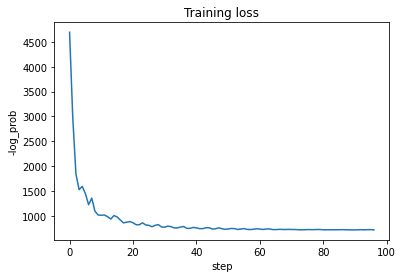

In [ ]:
import matplotlib.pyplot as plt


loss_plot = np.array([np.array([i, float(loss)]) for i, loss in enumerate(history)])
print(loss_plot[:, 0])
plt.figure(1)
plt.title("Training loss")
plt.xlabel("step")
plt.ylabel("-log_prob")
plt.plot(loss_plot[:, 0], loss_plot[:, 1])
plt.show()